#notebook setup

In [1]:
!pip install google-auth --upgrade
!pip install grpcio --upgrade

Requirement already up-to-date: google-auth in /usr/local/lib/python3.6/dist-packages (1.10.0)
Requirement already up-to-date: grpcio in /usr/local/lib/python3.6/dist-packages (1.26.0)


In [2]:
!pip install -qq tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 395.5MB 40kB/s 
     |████████████████████████████████| 3.8MB 31.1MB/s 
     |████████████████████████████████| 450kB 34.6MB/s 


In [3]:
import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.0.0-dev20191002
Found GPU at: /device:GPU:0


In [0]:
import sys
try:
    import ujson as json
except ImportError:
    try:
        import simplejson as json
    except ImportError:
        import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.preprocessing import MinMaxScaler
import pywt
import os
from PIL import Image
# import tensorflow as tf
from glob import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:

def plot_hist(input_history, filename):
  import os

  folder = ['acc', 'loss']

  directory = cwd + '/model_performance/'

  for f in folder:
    if not os.path.exists(directory + f):
      os.makedirs(directory + f)

  # summarize history for accuracy
  # fig, ax = plt.subplots(1,2)
  # plt.subplots_adjust(right=2)

  plt.plot(input_history.history['accuracy'])
  plt.plot(input_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.savefig(cwd+'/model_performance/acc/' + filename + '.jpg')
  plt.show()
  
  # summarize history for loss
  plt.plot(input_history.history['loss'])
  plt.plot(input_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  
  plt.savefig(cwd+'/model_performance/loss/' + filename + '.jpg')

# Data prep

In [7]:
%cd drive/'My Drive/CMS'
!pwd

/content/drive/My Drive/CMS
/content/drive/My Drive/CMS


In [8]:
img_folder = '/filtered_images'
!ls 'filtered_images'

0  1  2


class 0 : DYjets
class 1 : TTjets
class 2 : Wjets

## Train val size setting

In [9]:
cwd = os.getcwd()
img_path = cwd + img_folder

train_val_size = 1200

df = {}
data = []
for idx, x in enumerate(os.listdir(img_path)):
  if x.isdigit() and idx < 3:
    for idx2, pic in enumerate(os.listdir(img_path+'/'+str(x))):
      if idx2 < train_val_size:
        data.append((img_path+ '/' + x + '/' + pic , x))

df = pd.DataFrame(data, columns=['filename', 'class'])
df['class'] = df['class'].astype(int)
#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
print(len(df))
df.dtypes

                                            filename  class
0  /content/drive/My Drive/CMS/filtered_images/0/...      0
1  /content/drive/My Drive/CMS/filtered_images/2/...      2
2  /content/drive/My Drive/CMS/filtered_images/2/...      2
3  /content/drive/My Drive/CMS/filtered_images/0/...      0
4  /content/drive/My Drive/CMS/filtered_images/0/...      0
3600


filename    object
class        int64
dtype: object

In [10]:
from collections import Counter
cnt = Counter(df['class'])
cnt

Counter({0: 1200, 1: 1200, 2: 1200})

In [11]:
# Split into train and validation sets
train_percentage = .8
val_percentage = 0.1
test_percentage = 0.1

train_length = int(len(df) * train_percentage)
df_train = df[:train_length]

val_length = int(len(df) * val_percentage)
df_val = df[train_length : train_length+val_length]

test_length = int(len(df) * test_percentage)
df_test = df[ train_length + val_length : ]

# shuffle 
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

df_list = [df_train, df_val, df_test]
for df_part in df_list:
  print(len(df_part))

2880
360
360


#### image parsing

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 200,200
num_classes = len(set(df['class']))
batch_size = 120

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['filename'].values, tf.string),
                                                    tf.cast(df_train['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.shuffle(5000)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_test['filename'].values, tf.string),
                                                    tf.cast(df_test['class'].values, tf.int32) ))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.shuffle(5000)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [16]:
train_dataset

<BatchDataset shapes: ((120, 200, 200, 3), (120, 3)), types: (tf.float32, tf.float32)>

# VGG19

## Entirely frozen

In [17]:
base_vgg19_0 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

80142336/80134624 [==============================] - 3s 0us/step


In [0]:
# add a global spatial average pooling layer
x = base_vgg19_0.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

In [0]:
# this is the model we will train
base_vgg19_model = Model(inputs=base_vgg19_0.input, outputs=predictions)

In [20]:
for layer in base_vgg19_0.layers:
    print(layer.name)
    layer.trainable = False

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [21]:
for layer in base_vgg19_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_1  Trainable = False
block1_conv1  Trainable = False
block1_conv2  Trainable = False
block1_pool  Trainable = False
block2_conv1  Trainable = False
block2_conv2  Trainable = False
block2_pool  Trainable = False
block3_conv1  Trainable = False
block3_conv2  Trainable = False
block3_conv3  Trainable = False
block3_conv4  Trainable = False
block3_pool  Trainable = False
block4_conv1  Trainable = False
block4_conv2  Trainable = False
block4_conv3  Trainable = False
block4_conv4  Trainable = False
block4_pool  Trainable = False
block5_conv1  Trainable = False
block5_conv2  Trainable = False
block5_conv3  Trainable = False
block5_conv4  Trainable = False
block5_pool  Trainable = False
global_average_pooling2d  Trainable = True
dense  Trainable = True
dropout  Trainable = True
dense_1  Trainable = True
dropout_1  Trainable = True
dense_2  Trainable = True
dropout_2  Trainable = True
dense_3  Trainable = True


In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
opt1 = tf.keras.optimizers.RMSprop(lr=1e-4)
# compile the model (should be done *after* setting layers to non-trainable)
base_vgg19_model.compile(optimizer=opt1, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [23]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)
epochs = 50

#es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=15)

base_vgg19_model_filepath = 'entirely_frozen_vgg19_rmsprop.h5'
mcp = ModelCheckpoint(base_vgg19_model_filepath, monitor='accuracy', save_best_only=True, mode='max')

### Train the model with validation 
entirely_frozen_vgg19_history = base_vgg19_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks= [#es, 
                               mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 930s 39s/step - loss: 1.2282 - accuracy: 0.5031 - val_loss: 0.5632 - val_accuracy: 0.7333
Epoch 2/50
24/24 [==============================] - 17s 717ms/step - loss: 0.8663 - accuracy: 0.6330 - val_loss: 0.5642 - val_accuracy: 0.7167
Epoch 3/50
24/24 [==============================] - 17s 714ms/step - loss: 0.7530 - accuracy: 0.6649 - val_loss: 0.5389 - val_accuracy: 0.7333
Epoch 4/50
24/24 [==============================] - 17s 705ms/step - loss: 0.6983 - accuracy: 0.6851 - val_loss: 0.5460 - val_accuracy: 0.7361
Epoch 5/50
24/24 [==============================] - 17s 714ms/step - loss: 0.6657 - accuracy: 0.6951 - val_loss: 0.5132 - val_accuracy: 0.7556
Epoch 6/50
24/24 [==============================] - 17s 707ms/step - loss: 0.6603 - accuracy: 0.7125 - val_loss: 0.4973 - val_accuracy: 0.7750
Epoch 7/50
24/24 [==============================] - 17s 717ms/step - loss

#### testing the model

In [24]:
test_steps = int(len(df_test)/batch_size)

metrics = base_vgg19_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 101s 34s/step - loss: 0.5608 - accuracy: 0.7694
model accuracy: 0.76944447


#### plotting training

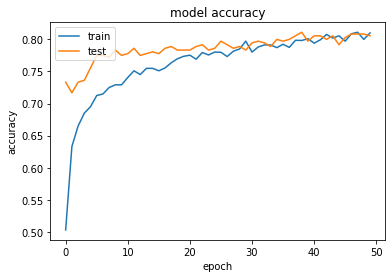

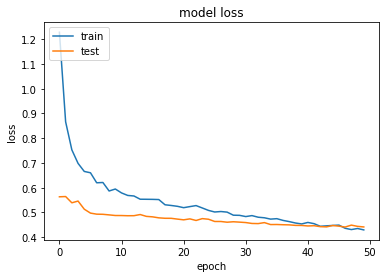

In [25]:
plot_hist(entirely_frozen_vgg19_history, 'entirely_frozen_vgg19_rmsprop')

#### saving the history of the fitting

In [26]:

with open(cwd + '/trainHistoryDict/entirely_frozen_vgg19_rmsprop_history.p', 'wb') as file_pi:
        pickle.dump(entirely_frozen_vgg19_history.history, file_pi)
print('history saved')

history saved


## Few layers unfrozen

#### loading model

In [0]:
base_vgg19_1 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_vgg19_1.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
few_unfrozen_vgg19_model = Model(inputs=base_vgg19_1.input, outputs=predictions)

In [30]:
for layer in base_vgg19_1.layers:
    print(layer.name)
    layer.trainable = False

input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [31]:
trainable_count = 0
per_layers = 0.2
num_model_layers = len(base_vgg19_1.layers)
starting_layer = int( num_model_layers * (1 - per_layers))
true_per_trained = (num_model_layers - starting_layer) / num_model_layers


print('true percentage of model trainable:', true_per_trained)

true percentage of model trainable: 0.22727272727272727


In [0]:

set_trainable = False
for idx, layer in enumerate(base_vgg19_1.layers):
    if idx == starting_layer:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False


In [35]:
for layer in few_unfrozen_vgg19_model.layers:
    print(layer.name,layer.trainable)

input_2 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_conv4 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_conv4 False
block4_pool False
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True
global_average_pooling2d_1 True
dense_4 True
dropout_3 True
dense_5 True
dropout_4 True
dense_6 True
dropout_5 True
dense_7 True


In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
# compile the model (should be done *after* setting layers to non-trainable)
few_unfrozen_vgg19_model.compile(optimizer=opt1, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [37]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'few_unfrozen_vgg19_rmsprop.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
few_unfrozen_vgg19_history = few_unfrozen_vgg19_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 18s 770ms/step - loss: 0.9621 - accuracy: 0.5323 - val_loss: 0.5483 - val_accuracy: 0.7306
Epoch 2/50
24/24 [==============================] - 18s 757ms/step - loss: 0.7257 - accuracy: 0.6736 - val_loss: 0.5759 - val_accuracy: 0.7500
Epoch 3/50
24/24 [==============================] - 19s 781ms/step - loss: 0.6299 - accuracy: 0.7135 - val_loss: 0.5996 - val_accuracy: 0.7722
Epoch 4/50
24/24 [==============================] - 18s 750ms/step - loss: 0.5932 - accuracy: 0.7420 - val_loss: 0.6125 - val_accuracy: 0.7361
Epoch 5/50
24/24 [==============================] - 18s 748ms/step - loss: 0.5715 - accuracy: 0.7531 - val_loss: 0.6449 - val_accuracy: 0.7500
Epoch 6/50
24/24 [==============================] - 18s 759ms/step - loss: 0.5328 - accuracy: 0.7740 - val_loss: 0.6587 - val_accuracy: 0.7361
Epoch 7/50
24/24 [==============================] - 18s 748ms/step - los

#### testing the model

In [38]:
test_steps = int(len(df_test)/batch_size)

metrics = few_unfrozen_vgg19_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 2s 580ms/step - loss: 3.2673 - accuracy: 0.7250
model accuracy: 0.725


#### plotting training

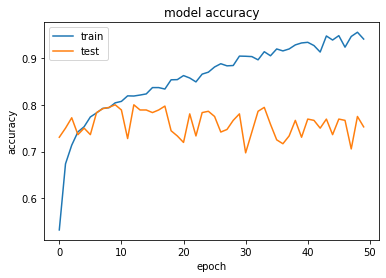

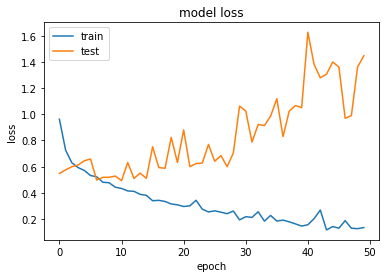

In [39]:
plot_hist(few_unfrozen_vgg19_history, 'few_unfrozen_vgg19_rmsprop')

#### saving the history of the fitting

In [40]:
with open(cwd + '/trainHistoryDict/few_unfrozen_vgg19_rmsprop_history.p', 'wb') as file_pi:
        pickle.dump(few_unfrozen_vgg19_history.history, file_pi)
print('history saved')

history saved


## Many layers unfrozen

#### loading model

In [0]:
base_vgg19_2 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_vgg19_2.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
many_unfrozen_vgg19_model = Model(inputs=base_vgg19_2.input, outputs=predictions)

In [44]:
for layer in base_vgg19_2.layers:
    print(layer.name)
    layer.trainable = False

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [45]:
trainable_count = 0
per_layers = 0.7
num_model_layers = len(base_vgg19_2.layers)
starting_layer = int( num_model_layers * (1 - per_layers))
true_per_trained = (num_model_layers - starting_layer) / num_model_layers


print('true percentage of model trainable:', true_per_trained)

true percentage of model trainable: 0.7272727272727273


In [0]:
set_trainable = False
for idx, layer in enumerate(base_vgg19_2.layers):
    if idx == starting_layer:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False

In [47]:
for layer in many_unfrozen_vgg19_model.layers:
    print(layer.name,layer.trainable)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool True
block3_conv1 True
block3_conv2 True
block3_conv3 True
block3_conv4 True
block3_pool True
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_conv4 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_conv4 True
block5_pool True
global_average_pooling2d_2 True
dense_8 True
dropout_6 True
dense_9 True
dropout_7 True
dense_10 True
dropout_8 True
dense_11 True


In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
# compile the model (should be done *after* setting layers to non-trainable)
many_unfrozen_vgg19_model.compile(optimizer=opt1, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [49]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'many_unfrozen_vgg19_rmsprop.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
many_unfrozen_vgg19_history = many_unfrozen_vgg19_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 27s 1s/step - loss: 1.2417 - accuracy: 0.3396 - val_loss: 1.0883 - val_accuracy: 0.3389
Epoch 2/50
24/24 [==============================] - 26s 1s/step - loss: 1.1491 - accuracy: 0.3434 - val_loss: 1.0975 - val_accuracy: 0.3389
Epoch 3/50
24/24 [==============================] - 25s 1s/step - loss: 1.0992 - accuracy: 0.3580 - val_loss: 0.8757 - val_accuracy: 0.5889
Epoch 4/50
24/24 [==============================] - 25s 1s/step - loss: 1.1336 - accuracy: 0.4056 - val_loss: 0.8788 - val_accuracy: 0.4778
Epoch 5/50
24/24 [==============================] - 25s 1s/step - loss: 0.8767 - accuracy: 0.5628 - val_loss: 0.6184 - val_accuracy: 0.6389
Epoch 6/50
24/24 [==============================] - 25s 1s/step - loss: 0.7442 - accuracy: 0.6299 - val_loss: 0.6830 - val_accuracy: 0.6667
Epoch 7/50
24/24 [==============================] - 25s 1s/step - loss: 0.7409 - accuracy:

#### testing the model

In [50]:
test_steps = int(len(df_test)/batch_size)

metrics = many_unfrozen_vgg19_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 2s 564ms/step - loss: 1.7182 - accuracy: 0.7278
model accuracy: 0.7277778


#### plotting training

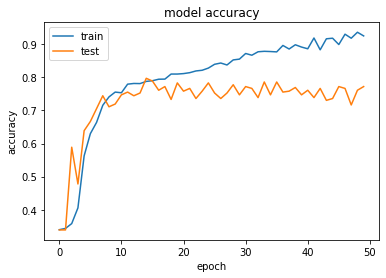

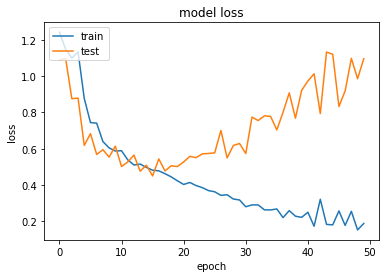

In [51]:
plot_hist(many_unfrozen_vgg19_history, 'many_unfrozen_vgg19_rmsprop')

#### saving the history of the fitting

In [52]:
with open(cwd + '/trainHistoryDict/many_unfrozen_vgg19_rmsprop_history.p', 'wb') as file_pi:
        pickle.dump(many_unfrozen_vgg19_history.history, file_pi)
print('history saved')

history saved


## entirely unfrozen

In [0]:
input_shapes = (200, 200, 3)
base_vgg19_3 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=input_shapes,pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_vgg19_3.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
unfrozen_vgg19_model = Model(inputs=base_vgg19_3.input, outputs=predictions)

In [56]:
for layer in unfrozen_vgg19_model.layers:
    print(layer.name)
    layer.trainable = True

input_4
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool
global_average_pooling2d_3
dense_12
dropout_9
dense_13
dropout_10
dense_14
dropout_11
dense_15


In [57]:
for layer in unfrozen_vgg19_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_4  Trainable = True
block1_conv1  Trainable = True
block1_conv2  Trainable = True
block1_pool  Trainable = True
block2_conv1  Trainable = True
block2_conv2  Trainable = True
block2_pool  Trainable = True
block3_conv1  Trainable = True
block3_conv2  Trainable = True
block3_conv3  Trainable = True
block3_conv4  Trainable = True
block3_pool  Trainable = True
block4_conv1  Trainable = True
block4_conv2  Trainable = True
block4_conv3  Trainable = True
block4_conv4  Trainable = True
block4_pool  Trainable = True
block5_conv1  Trainable = True
block5_conv2  Trainable = True
block5_conv3  Trainable = True
block5_conv4  Trainable = True
block5_pool  Trainable = True
global_average_pooling2d_3  Trainable = True
dense_12  Trainable = True
dropout_9  Trainable = True
dense_13  Trainable = True
dropout_10  Trainable = True
dense_14  Trainable = True
dropout_11  Trainable = True
dense_15  Trainable = True


In [58]:
unfrozen_vgg19_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0   

#### setting the optimizer

In [0]:
opt = tf.keras.optimizers.Adam(lr=0.001)
opt1 = tf.keras.optimizers.RMSprop(lr=1e-4)
# compile the model (should be done *after* setting layers to non-trainable)
unfrozen_vgg19_model.compile(optimizer=opt1, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [60]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'unfrozen_vgg19_rmsprop.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
unfrozen_vgg19_history = unfrozen_vgg19_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 33s 1s/step - loss: 1.2376 - accuracy: 0.3368 - val_loss: 1.0960 - val_accuracy: 0.3333
Epoch 2/50
24/24 [==============================] - 30s 1s/step - loss: 1.1076 - accuracy: 0.3438 - val_loss: 1.0936 - val_accuracy: 0.3389
Epoch 3/50
24/24 [==============================] - 31s 1s/step - loss: 1.0960 - accuracy: 0.3441 - val_loss: 1.0996 - val_accuracy: 0.3417
Epoch 4/50
24/24 [==============================] - 31s 1s/step - loss: 1.0927 - accuracy: 0.3545 - val_loss: 1.0406 - val_accuracy: 0.3389
Epoch 5/50
24/24 [==============================] - 31s 1s/step - loss: 1.0245 - accuracy: 0.4434 - val_loss: 2.9290 - val_accuracy: 0.3389
Epoch 6/50
24/24 [==============================] - 31s 1s/step - loss: 1.0731 - accuracy: 0.4795 - val_loss: 0.8965 - val_accuracy: 0.5333
Epoch 7/50
24/24 [==============================] - 31s 1s/step - loss: 0.7828 - accuracy:

#### testing the model

In [61]:
test_steps = int(len(df_test)/batch_size)

metrics = unfrozen_vgg19_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 2s 582ms/step - loss: 1.3129 - accuracy: 0.7194
model accuracy: 0.71944445


#### plotting training

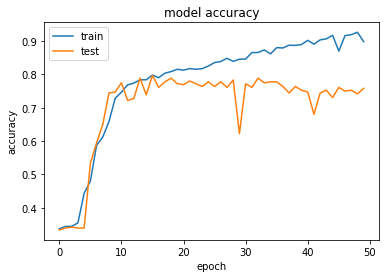

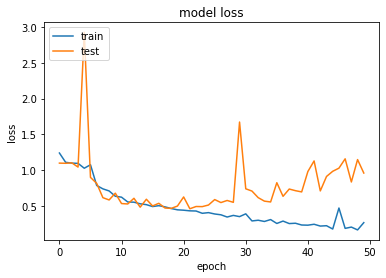

In [62]:
plot_hist(unfrozen_vgg19_history, 'unfrozen_vgg19_rmsprop')

#### saving the history of the fitting

In [63]:
with open(cwd + '/trainHistoryDict/unfrozen_vgg19_rmsprop_history.p', 'wb') as file_pi:
        pickle.dump(unfrozen_vgg19_history.history, file_pi)
print('history saved')

history saved
